<a href="https://colab.research.google.com/github/grootmax/DroDe/blob/main/DRODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!wget https://www.dropbox.com/s/7bud0mu909ufos3/archieve.zip?dl=0

--2021-10-17 09:19:27--  https://www.dropbox.com/s/7bud0mu909ufos3/archieve.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/7bud0mu909ufos3/archieve.zip [following]
--2021-10-17 09:19:28--  https://www.dropbox.com/s/raw/7bud0mu909ufos3/archieve.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucae1cc3f758b43c70a6bd6d78e8.dl.dropboxusercontent.com/cd/0/inline/BYNOZijXXs23vLS8MDaT7AM3_flFp-_Jdb67Ffqp7ovKKU7LHpJtjVp1DVRTw5CIt6pBkn8MeLRmrnZi_OZI7F2rA4IFwqcfSS66hP_GvMlibedk_W6KAkyx1skO9GYZbu6f2D3-areIHS8U6NlY5wG3/file# [following]
--2021-10-17 09:19:28--  https://ucae1cc3f758b43c70a6bd6d78e8.dl.dropboxusercontent.com/cd/0/inline/BYNOZijXXs23vLS8MDaT7AM3_flFp-_Jdb67Ffqp7ovKKU7LHpJtjVp1DVRTw5CIt6pBkn8MeLRmrnZi_OZI7

In [4]:
!unzip -q "/content/archieve.zip?dl=0"

In [5]:
# Imports required for this project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [6]:
# Creating the Pathlib PATH objects
train_path = Path("/content/train")
test_path = Path("/content/test")

In [7]:
# Getting Image paths 
train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x : str(x) , train_image_paths))

train_image_paths[:10]

['/content/train/drone/0269.jpg',
 '/content/train/drone/foto14936.jpg',
 '/content/train/drone/0313.jpg',
 '/content/train/drone/foto01944.jpg',
 '/content/train/drone/0330.jpg',
 '/content/train/drone/0044.jpg',
 '/content/train/drone/0283.jpg',
 '/content/train/drone/foto05221.jpg',
 '/content/train/drone/0028.jpg',
 '/content/train/drone/foto04409.jpg']

In [8]:
# Getting their respective labels 

def get_label(image_path):
    return image_path.split("/")[-2]

train_image_labels = list(map(lambda x : get_label(x) , train_image_paths))
train_image_labels[:10]

['drone',
 'drone',
 'drone',
 'drone',
 'drone',
 'drone',
 'drone',
 'drone',
 'drone',
 'drone']

In [9]:
from sklearn.preprocessing import LabelEncoder 

Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)

train_image_labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [10]:
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)

train_image_labels[:10]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [11]:
from sklearn.model_selection import train_test_split 

Train_paths , Val_paths , Train_labels , Val_labels = train_test_split(train_image_paths , train_image_labels , test_size = 0.25)

In [12]:
# Compute class weights 

classTotals = Train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)

{0: 2.153226, 1: 2.2531645, 2: 1.0}


In [13]:
# Function used for Transformation

def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

In [14]:
# Define IMAGE SIZE and BATCH SIZE 
IMG_SIZE = 96 
BATCH_SIZE = 32

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)          
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.1, -0.05))
])

In [15]:
# Function used to Create a Tensorflow Data Object
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
    
    dataset = dataset.repeat()
    return dataset

In [16]:
# Creating Train Dataset object and Verifying it
%time train_dataset = get_dataset(Train_paths , Train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 460 ms, sys: 23.9 ms, total: 484 ms
Wall time: 563 ms
(32, 96, 96, 3)
(32, 3)


drone is detected


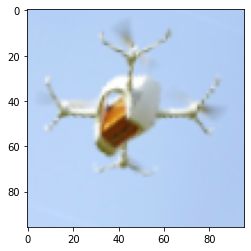

In [17]:
# View a sample Training Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [18]:
%time val_dataset = get_dataset(Val_paths , Val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 26.5 ms, sys: 3.04 ms, total: 29.5 ms
Wall time: 36.2 ms
(32, 96, 96, 3)
(32, 3)


drone is approaching  us


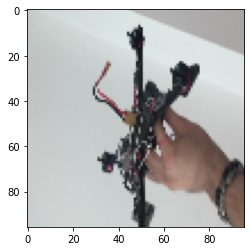

In [19]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [38]:
# Building EfficientNet model
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 3, 3, 1408)        7768569   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1408)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1408)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               180352    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 7,949,308
Trainable params: 7,881,733
Non-trainable params: 67,575
_________________________________________________________________


In [40]:
# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [60]:
# Train the model

history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=12,
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight = {0: 2.153226, 1: 2.2531645, 2: 1.0} )

Epoch 1/12
31/31 [==============================] - 95s 3s/step - loss: 1.4777 - accuracy: 0.5665 - precision: 0.6277 - recall: 0.4758 - val_loss: 0.8503 - val_accuracy: 0.6625 - val_precision: 0.6771 - val_recall: 0.6094
Epoch 2/12
31/31 [==============================] - 90s 3s/step - loss: 1.0520 - accuracy: 0.6920 - precision: 0.7316 - recall: 0.6353 - val_loss: 1.0675 - val_accuracy: 0.6375 - val_precision: 0.6492 - val_recall: 0.6187
Epoch 3/12
31/31 [==============================] - 88s 3s/step - loss: 0.9394 - accuracy: 0.7234 - precision: 0.7500 - recall: 0.6839 - val_loss: 0.8740 - val_accuracy: 0.6250 - val_precision: 0.6690 - val_recall: 0.5875
Epoch 4/12
31/31 [==============================] - 89s 3s/step - loss: 0.8091 - accuracy: 0.7467 - precision: 0.7706 - recall: 0.7214 - val_loss: 1.0228 - val_accuracy: 0.6625 - val_precision: 0.6634 - val_recall: 0.6406
Epoch 5/12
31/31 [==============================] - 89s 3s/step - loss: 0.6393 - accuracy: 0.8298 - precision: 0

In [70]:
model.layers[0].trainable = False

In [62]:
# Defining our callbacks 
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [63]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 3, 3, 1408)        7768569   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1408)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1408)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               180352    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 7,949,308
Trainable params: 180,739
Non-trainable params: 7,768,569
_________________________________________________________________


In [64]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight={0: 2.153226, 1: 2.2531645, 2: 1.0}
)

Epoch 1/8
31/31 [==============================] - 89s 2s/step - loss: 0.3959 - accuracy: 0.8881 - precision: 0.8941 - recall: 0.8851 - val_loss: 1.2110 - val_accuracy: 0.6844 - val_precision: 0.6930 - val_recall: 0.6844

Epoch 00001: val_loss improved from inf to 1.21102, saving model to best_weights.h5
Epoch 2/8
31/31 [==============================] - 88s 3s/step - loss: 0.3895 - accuracy: 0.9068 - precision: 0.9118 - recall: 0.9007 - val_loss: 1.5089 - val_accuracy: 0.5375 - val_precision: 0.5461 - val_recall: 0.5188

Epoch 00002: val_loss did not improve from 1.21102
Epoch 3/8
31/31 [==============================] - 89s 3s/step - loss: 0.3242 - accuracy: 0.9108 - precision: 0.9138 - recall: 0.9017 - val_loss: 1.4129 - val_accuracy: 0.6750 - val_precision: 0.6783 - val_recall: 0.6656

Epoch 00003: val_loss did not improve from 1.21102
Epoch 4/8
31/31 [==============================] - 88s 3s/step - loss: 0.3326 - accuracy: 0.9119 - precision: 0.9151 - recall: 0.9068 - val_loss: 1.

Testing Phase

In [78]:
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [79]:
model.load_weights("best_weights.h5")

In [80]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_labels = Le.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [96 , 96] , method="bilinear")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [81]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(32, 96, 96, 3)
(32, 3)


drone


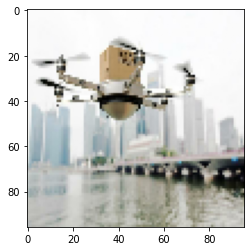

In [82]:
# View a sample Validation Image
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [83]:
# Evaluating the loaded model
loss, acc, prec, rec = model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

43/43 [==============================] - 34s 698ms/step - loss: 0.5378 - accuracy: 0.8433 - precision: 0.8466 - recall: 0.8403
 Testing Acc :  0.8432670831680298
 Testing Precision  0.8465530276298523
 Testing Recall  0.8403237462043762


Save Objects

In [84]:
# Save Model
model.save("FacialExpressionModel.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [85]:
# Save Label Encoder 
import pickle

def save_object(obj , name):
    pickle_obj = open(f"{name}.pck","wb")
    pickle.dump(obj, pickle_obj)
    pickle_obj.close()

In [86]:
save_object(Le, "LabelEncoder")